In [1]:
import numpy as np
import matplotlib.pyplot as plt
from seaborn import heatmap
import networkx as nx
import queue
from random import randint

In [23]:
def showBinaryMaze(mazeGrid):
    ''' Display the maze corresponding to a binary grid
        Input : 2D NumPy array with 0 and 1 as elements
        Output : Heatmap grid of the corresponding maze
    '''
    (height, width) = mazeGrid.shape
    mazeGrid = mazeGrid * 255                # just to match standard pixel values (0 to 255) in grayscale
    
    f = plt.figure(figsize = (width,height))
    heatmap(mazeGrid, vmin = 0, vmax = 255, cmap = "PiYG", cbar = False)
    
    
    
def showBinaryMazeProblem(mazeGrid, feed):
    ''' Display the maze corresponding to a binary grid
        Display "start" and "goal" position on the grid 
        Input : 2D NumPy array with 0 and 1 as elements
        Input : 2D coordinate of the "start" and "goal"
        Output : Heatmap grid of the maze with markers
    '''
    (height, width) = mazeGrid.shape
    mazeGrid = mazeGrid * 255
    
    mazeGrid[3, 3] = 192
    mazeGrid[feed[0], feed[1]] = 64
    
    f = plt.figure(figsize = (width,height))
    heatmap(mazeGrid, vmin = 0, vmax = 255, cmap = "PiYG", cbar = False)

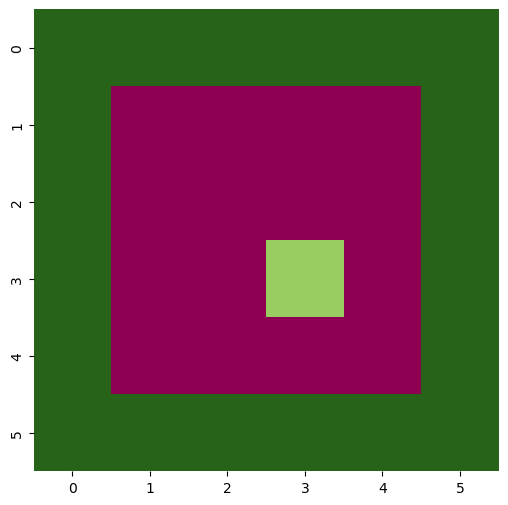

In [24]:
grid = [[1, 1, 1, 1, 1, 1],
        [1, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 1],
        [1, 0, 0, 0.75, 0, 1],
        [1, 0, 0, 0, 0, 1],
        [1, 1, 1, 1, 1, 1]]


grid = np.array(grid)

showBinaryMaze(grid)
        
        


In [25]:
def spawnFeed(grid):
    location = (randint(1,4), randint(1,4))
    if grid[location[0], location[1]] != 2:
        return location
    

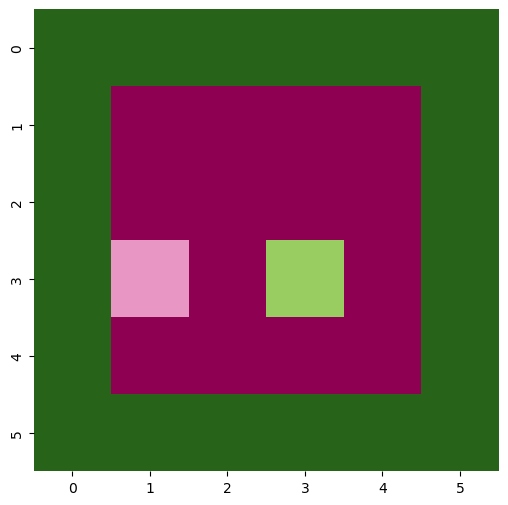

In [26]:
feed = spawnFeed(grid)
showBinaryMazeProblem(grid, feed)

In [27]:
# Create a Graph class
class GridGraph(object):
    ''' Class to represent a Graph
        Construction : Using Edges
    '''
    def __init__(self):
        self.edges = {}
    
    def all_edges(self):
        return self.edges
    
    def neighbors(self, node):
        return self.edges[node]    

In [28]:
# Function to convert a maze to a graph
def grid_to_graph(grid):
    ''' Converts a 2D binary maze to corresponding graph
        Input : 2D NumPy array with 0 and 1 as elements
        Output : MazeGraph corresponding to input maze
    '''
    gridGraph = GridGraph()
    (height, width) = grid.shape
    
    for i in range(height):
        for j in range(width):
            
            # Only consider blank cells as nodes
            if grid[i,j] in (0, 0.75):
                
                neighbors = []
                
                # Adjacent cell : Top
                if (i > 0) and grid[i-1,j] == 0:
                    neighbors.append(((i-1,j), 1))
                    
                # Adjacent cell : Left                
                if (j > 0) and grid[i,j-1] == 0:
                    neighbors.append(((i,j-1), 1))
                    
                # Adjacent cell : Bottom                    
                if (i < height - 1) and grid[i+1,j] == 0:
                    neighbors.append(((i+1,j), 1))

                # Adjacent cell : Right                    
                if (j < width - 1) and grid[i,j+1] == 0:
                    neighbors.append(((i,j+1), 1))

                # Insert edges in the graph
                if len(neighbors) > 0:
                    gridGraph.edges[(i,j)] = neighbors

    return gridGraph

In [29]:
# Convert the maze to a graph
gridGraph = grid_to_graph(grid)

# Print the edges with weights
gridGraph.all_edges()

{(1, 1): [((2, 1), 1), ((1, 2), 1)],
 (1, 2): [((1, 1), 1), ((2, 2), 1), ((1, 3), 1)],
 (1, 3): [((1, 2), 1), ((2, 3), 1), ((1, 4), 1)],
 (1, 4): [((1, 3), 1), ((2, 4), 1)],
 (2, 1): [((1, 1), 1), ((3, 1), 1), ((2, 2), 1)],
 (2, 2): [((1, 2), 1), ((2, 1), 1), ((3, 2), 1), ((2, 3), 1)],
 (2, 3): [((1, 3), 1), ((2, 2), 1), ((2, 4), 1)],
 (2, 4): [((1, 4), 1), ((2, 3), 1), ((3, 4), 1)],
 (3, 1): [((2, 1), 1), ((4, 1), 1), ((3, 2), 1)],
 (3, 2): [((2, 2), 1), ((3, 1), 1), ((4, 2), 1)],
 (3, 3): [((2, 3), 1), ((3, 2), 1), ((4, 3), 1), ((3, 4), 1)],
 (3, 4): [((2, 4), 1), ((4, 4), 1)],
 (4, 1): [((3, 1), 1), ((4, 2), 1)],
 (4, 2): [((3, 2), 1), ((4, 1), 1), ((4, 3), 1)],
 (4, 3): [((4, 2), 1), ((4, 4), 1)],
 (4, 4): [((3, 4), 1), ((4, 3), 1)]}

In [30]:
# Helper functions to work with the Maze with Path

def showBinaryGridPath(grid, path):
    ''' Display the maze corresponding to a binary grid
        Display path(s) superimposed on the binary grid 
        Input : 2D NumPy array with 0 and 1 as elements
        Input : 2D coordinates of the paths on the maze
        Output : Heatmap grid of the maze with the path
    '''
    (height, width) = grid.shape
    grid = grid * 255                # just to match standard pixel values (0 to 255) in grayscale
    
    for node in path:
        grid[node[0], node[1]] = 128     # half level of grayscale (0 to 255) to highlight the path
    
    grid[node[0], node[1]] = 192
    
    f = plt.figure(figsize = (width,height))
    heatmap(grid, vmin = 0, vmax = 255, cmap = "PiYG", cbar = False)

In [31]:
# Breadth-First-Search (BFS) with FIFO Queue

def breadth_first_search(mazeGraph, start, goal):
    ''' Function to perform BFS to find path in a graph
        Input  : Graph with the start and goal vertices
        Output : Dict of explored vertices in the graph
    '''
    frontier = queue.Queue()    # FIFO Queue for Frontier
    
    # initialization
    frontier.put(start)         # Add the start node to frontier
    explored = {}               # Dict of explored nodes {node : parentNode}
    explored[start] = None      # start node has no parent node
    processed = 0               # Count of total nodes processed
    
    while not frontier.empty():
        # get next node from frontier
        currentNode = frontier.get()
        processed += 1
        
        # stop when goal is reached
        if currentNode == goal:
            break
        
        # explore every single neighbor of current node
        for nextNode, weight in mazeGraph.neighbors(currentNode):
           
            # ignore if it has already been explored, helps to ensure we get optimal soln
            if nextNode not in explored:
                
                # put new node in frontier
                frontier.put(nextNode)
                
                # assign current node as parent
                explored[nextNode] = currentNode
    
    return explored, processed


# Reconstruct the path from the Dict of explored nodes {node : parentNode}
# Intuition : Backtrack from the goal node by checking successive parents

def reconstruct_path(explored, start, goal):
    currentNode = goal             # start at the goal node
    path = []                      # initiate the blank path

    # stop when backtrack reaches start node
    while currentNode != start:
        # grow the path backwards and backtrack
        path.append(currentNode)
        currentNode = explored[currentNode]

    path.append(start)             # append start node for completeness
    path.reverse()                 # reverse the path from start to goal

    return path



Breadth-First-Search (BFS)

Total nodes in maze : 15
Total nodes visited : 9  |  60.0 %
Final path distance : 3

Path through the Maze : [(3, 3), (3, 2), (3, 1)]


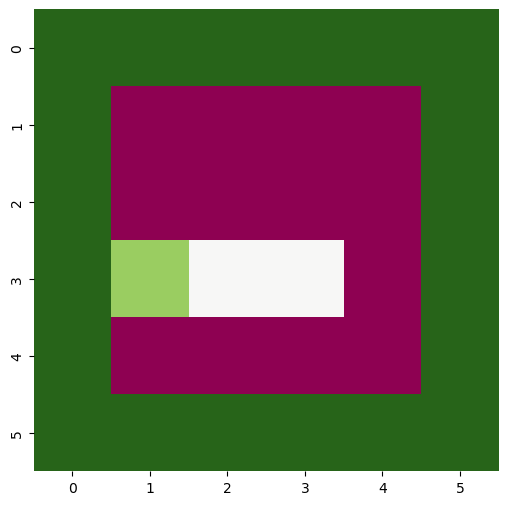

In [32]:
head = (3,3)
tail = head

START = head
GOAL = feed

# Run the BFS algorithm for path finding
nodesExplored, nodesProcessed = breadth_first_search(gridGraph, start = START, goal = GOAL)
path = reconstruct_path(nodesExplored, start = START, goal = GOAL)

# Basic measures for the algorithm
print("Breadth-First-Search (BFS)")
print()

totalNodes = np.count_nonzero(grid == 0)
print("Total nodes in maze :", totalNodes)
print("Total nodes visited :", nodesProcessed, " | ", np.round(100*(nodesProcessed/totalNodes),2), "%")
print("Final path distance :", len(path))
print()

# Print the path and show using helper functions
print("Path through the Maze :", path)
showBinaryGridPath(grid,path)

In [ ]:
head = feed
tail = head

START = head
GOAL = feed

# Run the BFS algorithm for path finding
nodesExplored, nodesProcessed = breadth_first_search(gridGraph, start = START, goal = GOAL)
path = reconstruct_path(nodesExplored, start = START, goal = GOAL)

# Basic measures for the algorithm
print("Breadth-First-Search (BFS)")
print()

totalNodes = np.count_nonzero(grid == 0)
print("Total nodes in maze :", totalNodes)
print("Total nodes visited :", nodesProcessed, " | ", np.round(100*(nodesProcessed/totalNodes),2), "%")
print("Final path distance :", len(path))
print()

# Print the path and show using helper functions
print("Path through the Maze :", path)
showBinaryGridPath(grid,path)

In [12]:
from turtle import Screen
